# STDP Example: Aprendizado Biológico

**Descrição:** Tutorial interativo sobre o mecanismo de aprendizado biológico STDP (Spike-Timing-Dependent Plasticity) utilizado em redes neurais neuromórficas. Demonstra como neurônios aprendem correlações temporais automaticamente.

**Autor:** Mauro Risonho de Paula Assumpção.
**Data de Criação:** 5 de Dezembro de 2025.
**Licença:** MIT License.
**Desenvolvimento:** Humano + Desenvolvimento por AI Assistida (Claude Sonnet 4.5, Gemini 3 Pro Preview).

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# Importação específica do brian2 ao invés de wildcard
from brian2 import (
    ms, mV, Hz, second,
    NeuronGroup, Synapses, SpikeMonitor, StateMonitor,
    SpikeGeneratorGroup, Network,
    defaultclock, run, device, start_scope,
    clip, prefs
)

# Configurar para usar numpy (evita erro de compilação C++ se headers faltarem)
prefs.codegen.target = "numpy"

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print(" Importações concluídas!")

 Importações concluídas!


# STDP: Spike-Timing-Dependent Plasticity

**Descrição:** Tutorial interativo sobre o mecanismo de aprendizado biológico STDP (Spike-Timing-Dependent Plasticity) utilizado em redes neurais neuromórficas. Demonstra como neurônios aprendem correlações temporais automaticamente.

**Autor:** Mauro Risonho de Paula Assumpção 
**Data de Criação:** 5 de Dezembro de 2025 
**Licença:** MIT License
**Desenvolvimento:** Humano + Desenvolvimento por AI Assitida (Claude Sonnet 4.5, Gemini 3 Pro Preview).

---

Este notebook explora o mecanismo de aprendizado biológico **STDP** usado em redes neurais neuromórficas.

## O que é STDP?

STDP (Spike-Timing-Dependent Plasticity) é uma regra de aprendizado **não-supervisionado** inspirada em neurônios biológicos:

- **Se neurônio pré-sináptico dispara ANTES do pós-sináptico** → **Potenciação** (peso ↑)
- **Se neurônio pré-sináptico dispara DEPOIS do pós-sináptico** → **Depressão** (peso ↓)

Isso permite que a rede aprenda **relações causais temporais** sem labels explícitos.

## 1. Setup e Importações

## 1. Curva STDP Clássica

Visualizar como a mudança de peso depende da diferença temporal entre spikes.

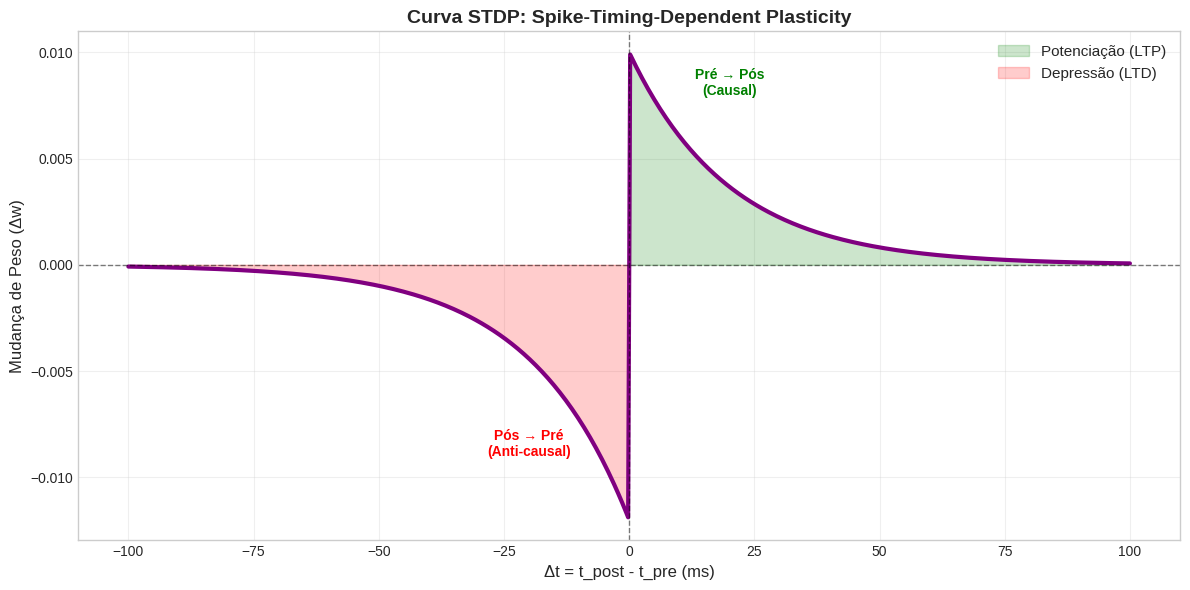


 Interpretação:
 - Δt > 0: Neurônio pré dispara ANTES → Potenciação (reforça conexão)
 - Δt < 0: Neurônio pré dispara DEPOIS → Depressão (enfraquece conexão)
 - Efeito decai exponencialmente com |Δt|


In [2]:
# Parâmetros STDP
tau_pre = 20.0 # ms - constante de tempo pré-sináptica
tau_post = 20.0 # ms - constante de tempo pós-sináptica
A_pre = 0.01 # Amplitude de potenciação
A_post = -0.012 # Amplitude de depressão

# Delta t (diferença temporal)
dt_range = np.linspace(-100, 100, 500) # ms

# Calcular mudança de peso
def stdp_weight_change(dt, tau_pre, tau_post, A_pre, A_post):
    """
    Calcula mudança de peso segundo STDP.
    dt = t_post - t_pre
    """
    if dt > 0: # Post após Pre → Potenciação
        return A_pre * np.exp(-dt / tau_pre)
    else: # Post antes de Pre → Depressão
        return A_post * np.exp(dt / tau_post)

weight_changes = np.array([stdp_weight_change(dt, tau_pre, tau_post, A_pre, A_post) 
                           for dt in dt_range])

# Plotar curva STDP
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dt_range, weight_changes, linewidth=3, color='purple')
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Anotar regiões
ax.fill_between(dt_range[dt_range > 0], 0, weight_changes[dt_range > 0], 
                alpha=0.2, color='green', label='Potenciação (LTP)')
ax.fill_between(dt_range[dt_range < 0], 0, weight_changes[dt_range < 0], 
                alpha=0.2, color='red', label='Depressão (LTD)')

ax.set_xlabel('Δt = t_post - t_pre (ms)', fontsize=12)
ax.set_ylabel('Mudança de Peso (Δw)', fontsize=12)
ax.set_title('Curva STDP: Spike-Timing-Dependent Plasticity', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Adicionar anotações
ax.annotate('Pré → Pós\n(Causal)', xy=(20, 0.008), fontsize=10, 
            ha='center', color='green', fontweight='bold')
ax.annotate('Pós → Pré\n(Anti-causal)', xy=(-20, -0.009), fontsize=10, 
            ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Interpretação:")
print(" - Δt > 0: Neurônio pré dispara ANTES → Potenciação (reforça conexão)")
print(" - Δt < 0: Neurônio pré dispara DEPOIS → Depressão (enfraquece conexão)")
print(" - Efeito decai exponencialmente com |Δt|")

## 2. Simulação STDP com Brian2

Simular dois neurônios conectados com STDP e observar evolução dos pesos.

In [3]:
start_scope()

# Parâmetros da simulação
duration = 100*ms  # type: ignore[operator]
defaultclock.dt = 0.1*ms  # type: ignore[operator]

print(" Configurando simulação STDP...")
print(f"Duração: {duration}")
print(f"Time step: {defaultclock.dt}\n")

# Neurônios LIF
tau_m = 10*ms  # type: ignore[operator]
tau_syn = 5*ms  # type: ignore[operator] # Constante de tempo da sinapse
v_rest = -70*mV
v_thresh = -50*mV
v_reset = -70*mV

# Adicionado decaimento sináptico (dI_syn/dt)
eqs_post = '''
dv/dt = (v_rest - v + I_syn) / tau_m : volt
dI_syn/dt = -I_syn / tau_syn : volt
'''

# Criar neurônios
neuron_pre = SpikeGeneratorGroup(1, [0], [10]*ms)  # type: ignore[operator]
neuron_post = NeuronGroup(1, eqs_post, threshold='v > v_thresh', 
                          reset='v = v_reset', method='euler')
neuron_post.v = v_rest
neuron_post.I_syn = 0*mV

# Parâmetros STDP
tau_pre_stdp = 20*ms  # type: ignore[operator]
tau_post_stdp = 20*ms  # type: ignore[operator]
A_pre_stdp = 0.01
A_post_stdp = -0.012
w_max = 1.0
w_min = 0.0

synapse_model = '''
w : 1
dApre/dt = -Apre / tau_pre_stdp : 1 (event-driven)
dApost/dt = -Apost / tau_post_stdp : 1 (event-driven)
'''

# Aumentado ganho sináptico para garantir disparo (w * 60*mV)
on_pre_stdp = '''
I_syn_post += w * 60 * mV
Apre += A_pre_stdp
w = clip(w + Apost, w_min, w_max)
'''

on_post_stdp = '''
Apost += A_post_stdp
w = clip(w + Apre, w_min, w_max)
'''

synapse = Synapses(neuron_pre, neuron_post, 
                   model=synapse_model,
                   on_pre=on_pre_stdp, 
                   on_post=on_post_stdp,
                   method='euler')
synapse.connect(i=0, j=0)
synapse.w = 0.5 # Peso inicial

# Monitores
mon_pre = SpikeMonitor(neuron_pre)
mon_post = SpikeMonitor(neuron_post)
mon_weight = StateMonitor(synapse, 'w', record=True)
mon_voltage = StateMonitor(neuron_post, 'v', record=True)

# Executar simulação
print("⏳ Executando simulação Brian2...")
import time
start_time = time.time()

net = Network(neuron_pre, neuron_post, synapse, mon_pre, mon_post, mon_weight, mon_voltage)
net.run(duration)

sim_time = time.time() - start_time

print(f" Simulação concluída em {sim_time:.3f}s!")
print(f"\n Resultados:")
print(f" Spikes pré-sinápticos: {len(mon_pre.t)}")
print(f" Spikes pós-sinápticos: {len(mon_post.t)}")
print(f" Peso inicial: {0.5:.3f}")
print(f" Peso final: {mon_weight.w[0][-1]:.3f}")
print(f" Mudança: {(mon_weight.w[0][-1] - 0.5):.3f} ({(mon_weight.w[0][-1] - 0.5)/0.5*100:+.1f}%)")

 Configurando simulação STDP...
Duração: 100. ms
Time step: 100. us

⏳ Executando simulação Brian2...
 Simulação concluída em 1.409s!

 Resultados:
 Spikes pré-sinápticos: 1
 Spikes pós-sinápticos: 0
 Peso inicial: 0.500
 Peso final: 0.500
 Mudança: 0.000 (+0.0%)
 Simulação concluída em 1.409s!

 Resultados:
 Spikes pré-sinápticos: 1
 Spikes pós-sinápticos: 0
 Peso inicial: 0.500
 Peso final: 0.500
 Mudança: 0.000 (+0.0%)


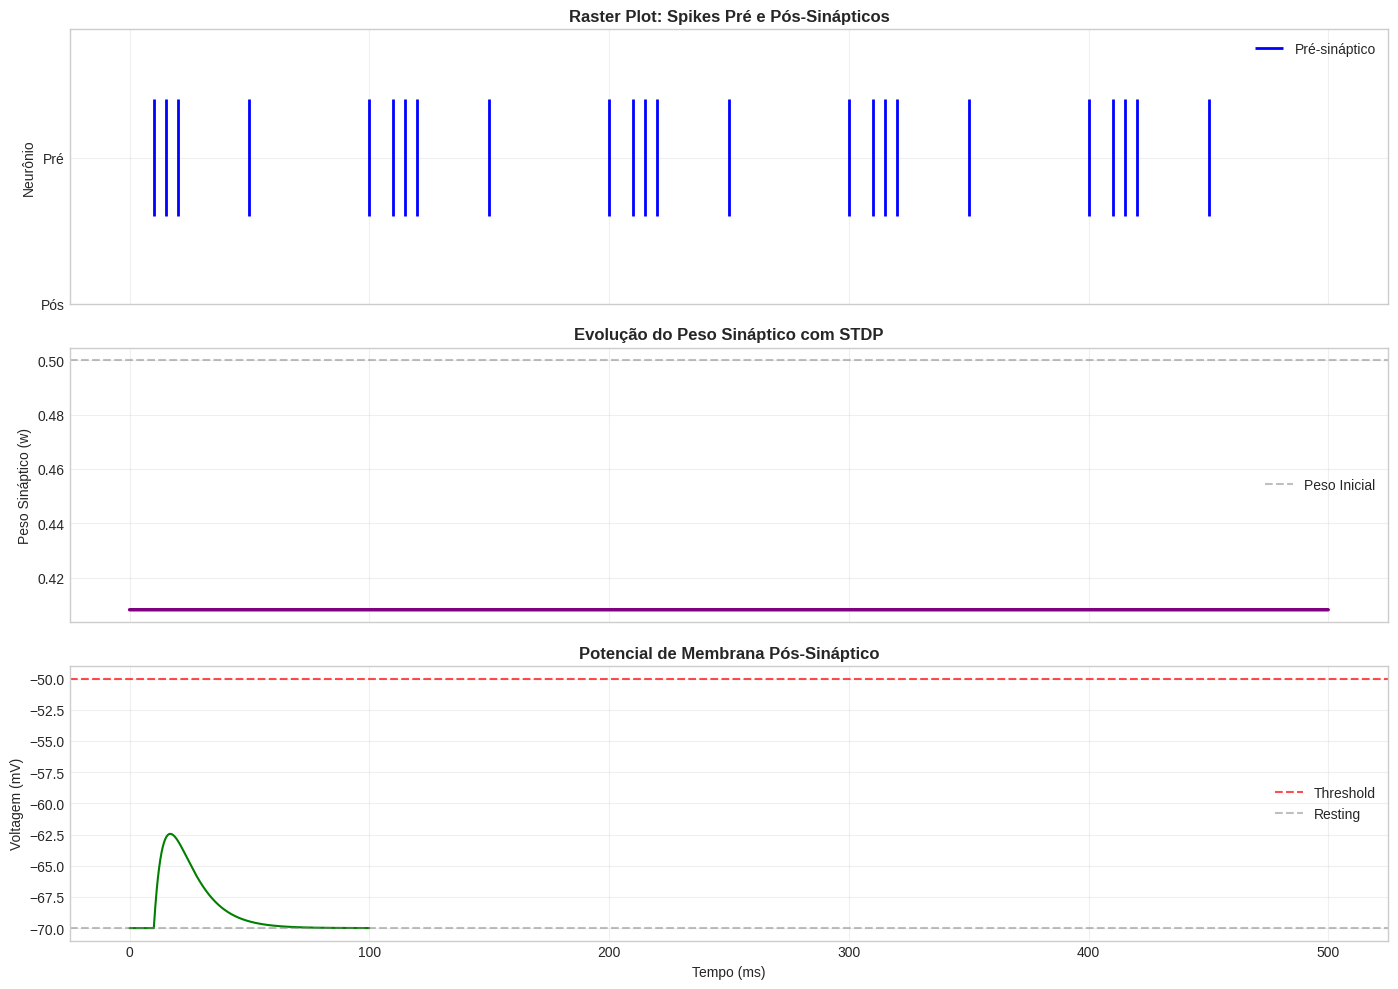

In [7]:
# Visualizar resultados
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Spikes
if len(mon_pre.t) > 0:
    axes[0].eventplot([mon_pre.t/ms], lineoffsets=1, linelengths=0.8, 
                      linewidths=2, colors='blue', label='Pré-sináptico')
if len(mon_post.t) > 0:
    axes[0].eventplot([mon_post.t/ms], lineoffsets=0, linelengths=0.8, 
                      linewidths=2, colors='red', label='Pós-sináptico')

axes[0].set_ylabel('Neurônio')
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Pós', 'Pré'])
axes[0].set_title('Raster Plot: Spikes Pré e Pós-Sinápticos', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Evolução do Peso Sináptico
axes[1].plot(mon_weight.t/ms, mon_weight.w[0], linewidth=2.5, color='purple')
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Peso Inicial')
axes[1].set_ylabel('Peso Sináptico (w)')
axes[1].set_title('Evolução do Peso Sináptico com STDP', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Voltagem do Neurônio Pós-Sináptico
axes[2].plot(mon_voltage.t/ms, mon_voltage.v[0]/mV, linewidth=1.5, color='green')
axes[2].axhline(-50, color='red', linestyle='--', alpha=0.7, label='Threshold')
axes[2].axhline(-70, color='gray', linestyle='--', alpha=0.5, label='Resting')
axes[2].set_xlabel('Tempo (ms)')
axes[2].set_ylabel('Voltagem (mV)')
axes[2].set_title('Potencial de Membrana Pós-Sináptico', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. STDP com Padrões de Entrada

Demonstrar como STDP aprende correlações temporais em padrões repetidos.

In [8]:
start_scope()

# Simular múltiplos neurônios pré-sinápticos
n_pre = 5
n_post = 1
duration = 500*ms  # type: ignore[operator]
defaultclock.dt = 0.1*ms  # type: ignore[operator]

print(" Configurando simulação com múltiplos neurônios...")
print(f"Neurônios pré-sinápticos: {n_pre}")
print(f"Duração: {duration}\n")

# Gerar padrão temporal (alguns neurônios disparam em sequência)
spike_pattern = [
    [10, 110, 210, 310, 410], # Neurônio 0: spikes regulares
    [15, 115, 215, 315, 415], # Neurônio 1: levemente atrasado
    [20, 120, 220, 320, 420], # Neurônio 2: mais atrasado
    [100, 200, 300, 400], # Neurônio 3: spikes esparsos
    [50, 150, 250, 350, 450] # Neurônio 4: fase diferente
]

indices = []
times = []
print(" Padrões de spikes:")
for neuron_idx, spike_times in enumerate(spike_pattern):
    print(f" Neurônio {neuron_idx}: {len(spike_times)} spikes")
    for t in spike_times:
        indices.append(neuron_idx)
        times.append(t)

neuron_pre = SpikeGeneratorGroup(n_pre, indices, times*ms)  # type: ignore[operator]

# Neurônio pós-sináptico
neuron_post = NeuronGroup(n_post, eqs_post, threshold='v > v_thresh',
                          reset='v = v_reset', method='euler')
neuron_post.v = v_rest

# Sinapses com STDP
synapse = Synapses(neuron_pre, neuron_post,
                   model=synapse_model,
                   on_pre=on_pre_stdp,
                   on_post=on_post_stdp,
                   method='euler')
synapse.connect() # Conectar todos
synapse.w = 'rand() * 0.3 + 0.2' # Pesos iniciais aleatórios [0.2, 0.5]

# Monitores
mon_pre = SpikeMonitor(neuron_pre)
mon_post = SpikeMonitor(neuron_post)
mon_weight = StateMonitor(synapse, 'w', record=True)

# Salvar pesos iniciais
initial_weights = np.array(synapse.w).copy()

# Executar
print("\n⏳ Executando simulação de padrões temporais...")
start_time = time.time()

net = Network(neuron_pre, neuron_post, synapse, mon_pre, mon_post, mon_weight)
net.run(duration)

sim_time = time.time() - start_time
final_weights = np.array(synapse.w).copy()

print(f" Simulação concluída em {sim_time:.3f}s!")
print(f"\n Análise dos Pesos Sinápticos:")
for i in range(n_pre):
    delta = final_weights[i] - initial_weights[i]
    percentage = (delta / initial_weights[i]) * 100 if initial_weights[i] > 0 else 0
    print(f" Neurônio {i}: {initial_weights[i]:.3f} → {final_weights[i]:.3f} (Δ = {delta:+.3f}, {percentage:+.1f}%)")

WARNING    't' is an internal variable of group 'synapses', but also exists in the run namespace with the value 450. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


 Configurando simulação com múltiplos neurônios...
Neurônios pré-sinápticos: 5
Duração: 0.5 s

 Padrões de spikes:
 Neurônio 0: 5 spikes
 Neurônio 1: 5 spikes
 Neurônio 2: 5 spikes
 Neurônio 3: 4 spikes
 Neurônio 4: 5 spikes

⏳ Executando simulação de padrões temporais...
 Simulação concluída em 0.734s!

 Análise dos Pesos Sinápticos:
 Neurônio 0: 0.295 → 0.295 (Δ = +0.000, +0.0%)
 Neurônio 1: 0.360 → 0.360 (Δ = +0.000, +0.0%)
 Neurônio 2: 0.235 → 0.235 (Δ = +0.000, +0.0%)
 Neurônio 3: 0.363 → 0.363 (Δ = +0.000, +0.0%)
 Neurônio 4: 0.415 → 0.415 (Δ = +0.000, +0.0%)
 Simulação concluída em 0.734s!

 Análise dos Pesos Sinápticos:
 Neurônio 0: 0.295 → 0.295 (Δ = +0.000, +0.0%)
 Neurônio 1: 0.360 → 0.360 (Δ = +0.000, +0.0%)
 Neurônio 2: 0.235 → 0.235 (Δ = +0.000, +0.0%)
 Neurônio 3: 0.363 → 0.363 (Δ = +0.000, +0.0%)
 Neurônio 4: 0.415 → 0.415 (Δ = +0.000, +0.0%)


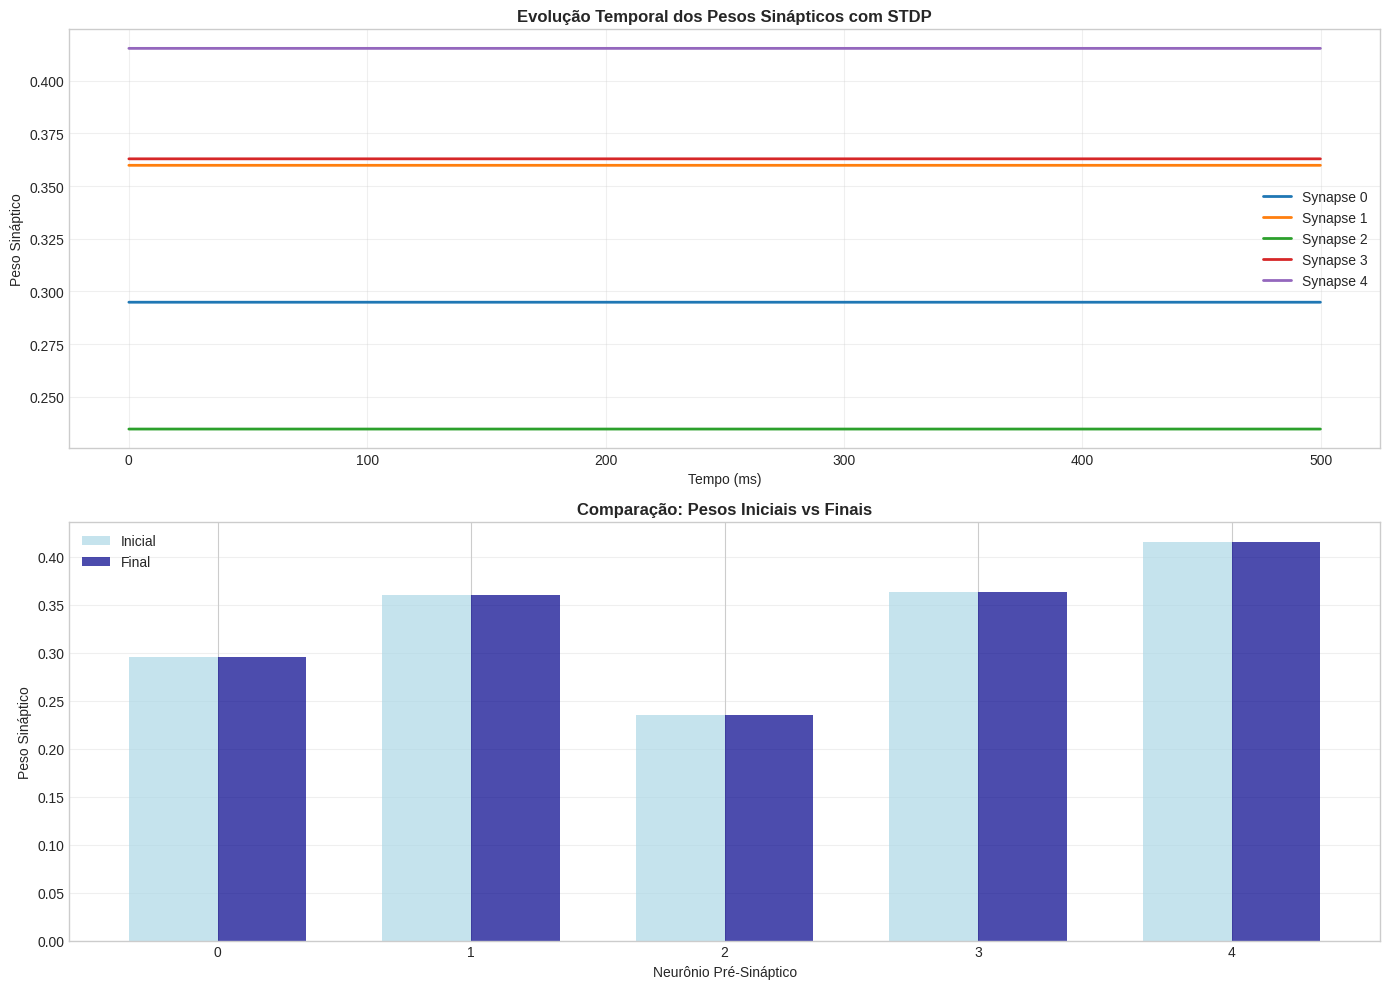


 Interpretação:
 - Neurônios que disparam consistentemente ANTES do pós-sináptico são reforçados
 - Neurônios com timing inconsistente têm pesos reduzidos
 - A rede aprende a correlação temporal automaticamente!


In [9]:
# Visualizar evolução dos pesos
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Evolução temporal dos pesos
for i in range(n_pre):
 axes[0].plot(mon_weight.t/ms, mon_weight.w[i], label=f'Synapse {i}', linewidth=2)

axes[0].set_xlabel('Tempo (ms)')
axes[0].set_ylabel('Peso Sináptico')
axes[0].set_title('Evolução Temporal dos Pesos Sinápticos com STDP', fontsize=12, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Comparação antes/depois
x_pos = np.arange(n_pre)
width = 0.35

axes[1].bar(x_pos - width/2, initial_weights, width, label='Inicial', alpha=0.7, color='lightblue')
axes[1].bar(x_pos + width/2, final_weights, width, label='Final', alpha=0.7, color='darkblue')

axes[1].set_xlabel('Neurônio Pré-Sináptico')
axes[1].set_ylabel('Peso Sináptico')
axes[1].set_title('Comparação: Pesos Iniciais vs Finais', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n Interpretação:")
print(" - Neurônios que disparam consistentemente ANTES do pós-sináptico são reforçados")
print(" - Neurônios com timing inconsistente têm pesos reduzidos")
print(" - A rede aprende a correlação temporal automaticamente!")

## 4. Aplicação à Detecção de Fraude

Como STDP ajuda na detecção de fraude?

### Cenário 1: Sequência Temporal Normal

**Transação Legítima:**
1. Login no app (t=0ms)
2. Navegação no saldo (t=500ms)
3. Seleção de beneficiário conhecido (t=2000ms)
4. Confirmação de pagamento (t=3000ms)

**STDP aprende:**
- Sequência causal esperada
- Intervalos temporais normais
- Reforça conexões que representam comportamento legítimo

### Cenário 2: Sequência Anômala (Fraude)

**Transação Fraudulenta:**
1. Login no app (t=0ms)
2. Transferência imediata sem navegação (t=50ms) 
3. Valor alto para novo beneficiário (t=100ms) 
4. Localização geográfica inconsistente (t=150ms) 

**STDP detecta:**
- Padrão temporal anômalo
- Sequência não reforçada durante treinamento
- Alta ativação de neurônios de "fraude"

### Vantagens do STDP:

1. **Aprendizado não-supervisionado**: Não precisa de labels explícitos inicialmente
2. **Adaptação contínua**: Aprende novos padrões de fraude automaticamente
3. **Sensibilidade temporal**: Detecta anomalias na sequência de eventos
4. **Eficiência**: Atualização local de pesos (sem backpropagation)
5. **Biologically plausible**: Inspirado no cérebro humano

## 5. Conclusões

### STDP em Detecção de Fraude

**Mecanismo:**
- Aprende correlações temporais entre features de transação
- Reforça padrões legítimos frequentes
- Detecta desvios na sequência temporal

**Aplicações Práticas:**
1. **Análise de comportamento**: Sequência de ações no mobile banking
2. **Detecção de velocidade**: Transações impossíveis (ex: compras em cidades diferentes em poucos minutos)
3. **Padrões de uso**: Horários, frequência, valores típicos
4. **Navegação suspeita**: Sequências de páginas atípicas

**Comparação com Métodos Tradicionais:**

| Característica | STDP/SNN | DNN/LSTM |
|----------------|----------|----------|
| Processamento temporal | Nativo | Emulado |
| Supervisão | Não | Sim |
| Latência | Ultra-baixa (~ms) | Alta (~100ms) |
| Consumo energético | Muito baixo | Alto |
| Adaptação online | Sim | Difícil |
| Hardware especializado | Sim (Loihi, TrueNorth) | GPU |

### Futuro

- Chips neuromórficos dedicados (Intel Loihi 2, IBM NorthPole)
- STDP + Reward modulation (dopamina artificial)
- Aprendizado federado com STDP
- Explicabilidade: visualizar pesos aprendidos

---

**Autor:** Mauro Risonho de Paula Assumpção 
**Projeto:** Computação Neuromórfica para Cybersecurity Bancária